# Mini Challenge: Gradient Descent

- Authoren: Sandro **Balz**, Stefan **Binkert**, Christoph **Elmiger**  
- Studiengang: FHNW Data Science BSc  
- Modul: Vertiefende Themen der Analysis  
- Fachexperte: Stefan Hackstein

*Zuletzt vollständig ausgeführt am 22.3.2025 in 2:03 Minuten*

## Einleitung

Dieses Jupyter Notebook wurde im Rahmen der Mini Challenge "Gradient Descent" aus der Veranstaltung Vertiefung Analysis erstellt. Ziel dieser Aufgabe ist es, ein grundlegendes Verständnis für numerische Näherungsverfahren in höheren Dimensionen zu entwickeln – insbesondere für den Gradient Descent und dessen Anwendung in neuronalen Netzwerken.

Anhand des MNIST-Datensatzes wird zunächst eine Datenexploration durchgeführt, anschliessend wird ein neuronales Netzwerk vollständig mit NumPy implementiert. Dabei werden alle wesentlichen Komponenten wie Forward- und Backward-Pass, Parameter-Updates sowie Trainings- und Evaluationsfunktionen selbst entwickelt. Abschliessend erfolgt eine Analyse des Trainingsverhaltens unter Variation der Lernrate und Netzwerkarchitektur.

Dieses Notebook dokumentiert nicht nur den Lösungsweg, sondern auch die wichtigsten Lernfortschritte, Herausforderungen und Erkenntnisse im Sinne eines Lerntagebuchs. Zur Unterstützung kamen auch KI-gestützte Tools wie ChatGPT zum Einsatz, deren Verwendung transparent offengelegt und reflektiert wird.

## Inhalt

### Aufgabe 1 – Datenimport und Exploration

- Laden des MNIST-Datensatzes mit torchvision
- Analyse von Struktur, Format und Labelverteilung
- Visuelle Exploration der Ziffern (Beispiele und Verteilungsgrafiken)

### Aufgabe 2 – Implementierung eines linearen Layers in NumPy

- Manuelle Implementierung eines vollvernetzten Layers (Forward, Backward, Update)
- He-Initialisierung und Gradient Clipping
- Verifikation durch explizite Unittests und händische Kontrollrechnung

### Aufgabe 3 – Einfaches neuronales Netz (Binary Classification)

- Konstruktion eines Netzwerks mit einem Hidden Layer
- Klassifikation einer Zielziffer vs. Rest
- Implementierung und mathematische Herleitung von Kosten- und Evaluationsfunktionen
- Diskussion der Funktionswahl und möglicher Alternativen

### Aufgabe 4 – Hyperparameter-Tuning und Trainingsevaluation

- Systematische Variation von Lernrate und Hidden-Layer-Größe
- Training über mehrere Epochen und Vergleich der Modelle
- Darstellung und Interpretation von Trainings- und Testverläufen
- Diskussion möglicher Trainingsprobleme und ihrer Ursachen

### Aufgabe 5 – Erweiterung zum Mehrklassen-Klassifikator

- Erweiterung auf ein Netzwerk mit 3 Hidden Layern und 10 Outputs
- Training mit Mini-Batches
- Wahl und Vergleich von Evaluations- und Kostenfunktionen für Multiklassen-Setups
- Hyperparameteranalyse und Begründung der finalen Architektur

### Anhang
- Reflexion zur KI-Nutzung (inkl. Beispielchat)

## Aufgabe 1 – Laden und Erkunden des MNIST-Datensatzes

In dieser Aufgabe nutzen wir das `torchvision`-Paket, um den bekannten MNIST-Datensatz zu laden, und analysieren dessen Struktur. Ziel ist es, ein erstes Verständnis für die Datenbasis zu entwickeln, mit der wir später ein neuronales Netzwerk trainieren werden.

### Import von Libraries

Zunächst importieren wir alle benötigten Bibliotheken. Für diese Aufgabe dürfen wir neben `numpy` und `matplotlib` auch `torchvision` verwenden, um die MNIST-Daten bequem herunterzuladen und zu transformieren.

In [34]:
import numpy as np
import matplotlib.pyplot as plt

# Nur für Aufgabe 1
from torchvision import datasets, transforms

# Um zu überprüfen, wie lange das Notebook läuft
from time import time
t_anfang = time()


### Verwendung von torchvision zum Laden der Daten

Hier definieren wir die nötige Transformation und laden den MNIST-Datensatz. Dabei werden die Bilddaten direkt in Tensoren umgewandelt, um sie später leichter verarbeiten zu können.

In [35]:
# Transformation: Wandelt PIL-Bild in Tensor im Bereich [0, 1] um
transform = transforms.ToTensor()

# Download und Laden des MNIST-Datensatzes (Trainings- und Testdaten)
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset  = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

### Überblick über Struktur, Verteilung und Eigenschaften des Datensatzes

Nach dem Laden werfen wir einen genaueren Blick auf die Struktur der Daten. Wir untersuchen u.a. die Anzahl der Datensätze, die Form der Bilddaten, die Labelverteilung sowie den Wertebereich der Pixel.

In [36]:
# Überblick über Datensatz-Grösse und Struktur
print("Trainingsdaten: ", len(train_dataset))
print("Testdaten: ", len(test_dataset))

# Datentyp der Bilder und Labels
print(f"Unsere Testdaten haben den Typ {type(train_dataset)}")
print(f"Die Bilder-Tensoren haben Typ {type(test_dataset[0][0])}, die Labels Typ {type(test_dataset[0][1])}")

# Dimension eines einzelnen Bildes
print(f"Bilder haben Shape {tuple(train_dataset[0][0].size())} (1 Kanal, 28px hoch, 28px breit), pro Bild haben wir also {1*28*28} Pixel")

# Anzahl der unterschiedlichen Ziffernlabels
print(f"Wir haben {len(set(train_dataset.targets.tolist()))} einzigartige Labels (Zahlen 0 - 9).")

# Bereich der Pixelwerte (zwischen 0 und 255)
print(f"Der Bereich der Pixelwerte liegt zwischen {np.min(train_dataset.data.tolist())} und {np.max(train_dataset.data.tolist())}")
print(f"Der Durchschnitt der Pixelwerte liegt bei {np.mean(train_dataset.data.tolist()):.2f}")

Trainingsdaten:  60000
Testdaten:  10000
Unsere Testdaten haben den Typ <class 'torchvision.datasets.mnist.MNIST'>
Die Bilder-Tensoren haben Typ <class 'torch.Tensor'>, die Labels Typ <class 'int'>
Bilder haben Shape (1, 28, 28) (1 Kanal, 28px hoch, 28px breit), pro Bild haben wir also 784 Pixel
Wir haben 10 einzigartige Labels (Zahlen 0 - 9).
Der Bereich der Pixelwerte liegt zwischen 0 und 255
Der Durchschnitt der Pixelwerte liegt bei 33.32


### Visualisierung erster Beispiele

Um ein besseres Verständnis für den MNIST-Datensatz zu entwickeln, betrachten wir zunächst Beispielbilder aus dem Testdatensatz. Für jede Ziffer von 0 bis 9 werden jeweils 15 zufällige Beispiele angezeigt. So gewinnen wir einen visuellen Eindruck von der Vielfalt und Unterschiedlichkeit der handschriftlichen Zifferndarstellung.

Anschliessend analysieren wir die Häufigkeitsverteilung der Labels in Trainings- und Testdaten. Diese Information ist wichtig, um potenzielle Ungleichgewichte zu erkennen, die das Training beeinflussen könnten.

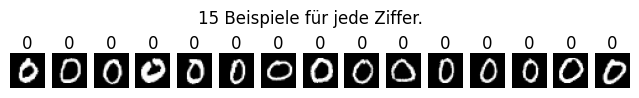

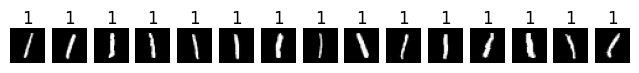

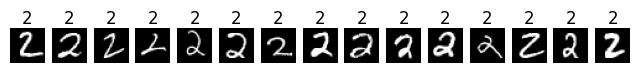

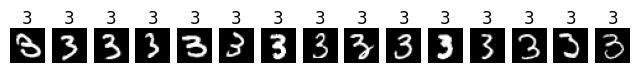

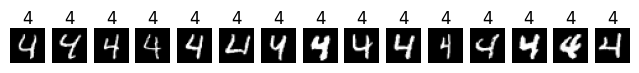

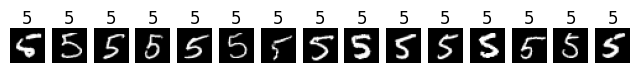

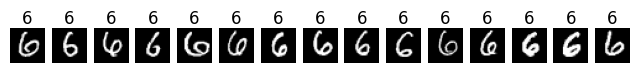

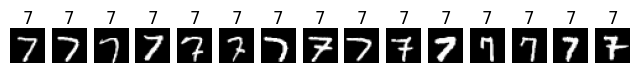

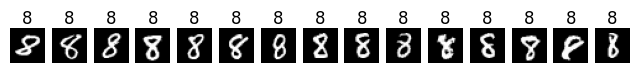

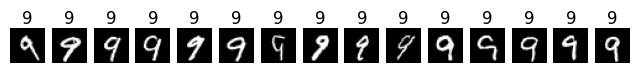

In [37]:
# Zeige für jede Ziffer (0–9) eine Reihe mit Beispielbildern
show_how_many = 15 # Anzahl Beispiele pro Ziffer


for i in range(10):
    
    number_to_show = i
    nums = [] # Liste der Bilder
    j = 0
    # Sammle die ersten 15 Bilder der Ziffer i
    while len(nums) < show_how_many:
        img, label = test_dataset[j]
        if label == number_to_show:
            nums.append(img)
        j += 1
        
    # Erzeuge eine Zeile von Bildern
    fig, axes = plt.subplots(1, show_how_many, figsize=(8,2))
    plt.subplots_adjust(hspace=-3)  # Adjust this value to control spacing
    if i == 0:
        plt.suptitle(f"{show_how_many} Beispiele für jede Ziffer.", y=.8)
    for j, ax in enumerate(axes):
        img = nums[j]
        ax.imshow(img.squeeze(), cmap='gray')
        ax.set_title(f"{label}", y=.9)
        ax.axis('off')
plt.show()

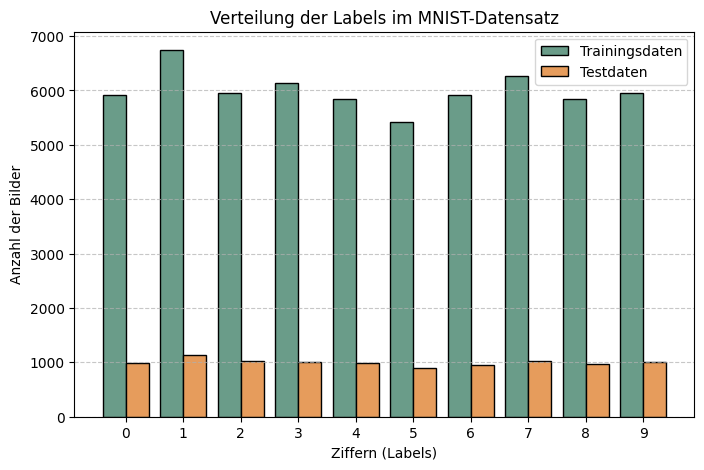

In [38]:
# Labels extrahieren aus Trainings- und Testdaten
train_labels = [train_dataset[i][1] for i in range(len(train_dataset))]
test_labels = [test_dataset[i][1] for i in range(len(test_dataset))]

# Zähle Vorkommen pro Klasse (0–9)
train_counts = np.bincount(train_labels, minlength=10)
test_counts = np.bincount(test_labels, minlength=10)

# Setup für Balkendiagramm
bar_width = 0.4
indices = np.arange(10)

# Farben für bessere Lesbarkeit
train_color = "#6a9c89"  # Sanftes Grün
test_color = "#e69c5c"   # Warmes Orange

# Plot erstellen
plt.figure(figsize=(8, 5))
plt.bar(indices - bar_width/2, train_counts, width=bar_width, color=train_color, edgecolor='black', label="Trainingsdaten")
plt.bar(indices + bar_width/2, test_counts, width=bar_width, color=test_color, edgecolor='black', label="Testdaten")

# Achsen und Titel
plt.xticks(indices, range(10))
plt.xlabel("Ziffern (Labels)")
plt.ylabel("Anzahl der Bilder")
plt.title("Verteilung der Labels im MNIST-Datensatz")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

## Aufgabe 2 – Implementierung eines linearen Layers in NumPy

In dieser Aufgabe erstellen wir einen einfachen linearen Layer vollständig mit `NumPy`. Ziel ist es, ein tiefes Verständnis für die Funktionsweise neuronaler Netze zu entwickeln – ohne High-Level-Bibliotheken wie PyTorch oder TensorFlow. 

Der Layer soll in der Lage sein, Eingabedaten zu verarbeiten (Forward-Pass), Gradienten für das Training zu berechnen (Backward-Pass) und seine Parameter über Gradient Descent zu aktualisieren (Update-Schritt). Damit bildet er die zentrale Recheneinheit für das spätere Netzwerk in Aufgabe 3–5. 

<img src="nn.png" alt="Neural Network image" width="720" height="520"/>

###  Klasse `LinearLayer`: Forward, Backward und Update

Die Klasse `LinearLayer` bildet einen vollständig verbundenen, linearen Layer. Sie besitzt drei zentrale Methoden:

- `forward(x)`: Berechnet die Ausgabe $z = XW^T + b $
- `backward(d_out)`: Berechnet die Gradienten der Gewichte und Biases
- `update(learning_rate)`: Führt einen Schritt des Gradientenverfahrens durch

Zusätzlich verwenden wir **He-Initialisierung**, um die Gewichte geeignet zu starten – eine gängige Praxis bei ReLU-Aktivierungen. Zur Stabilisierung (z.B. um Overflow bei zu hohen Lernraten zu vermeiden) werden die Gradienten vor dem Update auf eine maximale L2-Norm begrenzt.

In [39]:
class LinearLayer:
    """
    Eine vollständig verbundene (dense) lineare Schicht:
    Berechnet: output = x @ W^T + b^T

    Attributes:
        W (ndarray): Gewichtsmatrix (shape: [output_dim, input_dim])
        b (ndarray): Bias-Vektor (shape: [output_dim, 1])
        x (ndarray): Eingabevektor für den Backward-Pass
        dW (ndarray): Gradienten der Gewichte
        db (ndarray): Gradienten des Bias
    """

    def __init__(self, input_dim, output_dim):
        """
        Initialisiert die Parameter der Schicht (Gewichte und Bias).
        Gewichte werden per He-Initialisierung gesetzt.
        """
        self.W = np.random.randn(output_dim, input_dim) * np.sqrt(2.0 / input_dim)  # He-Init
        self.b = np.zeros((output_dim, 1))
        self.x = None     # wird im Forward gespeichert
        self.dW = None    # Gradient der Gewichte
        self.db = None    # Gradient des Bias

    def forward(self, x):
        """
        Führt den Vorwärtsdurchlauf durch: Berechnung von x @ W^T + b^T.

        Args:
            x (ndarray): Eingabe mit Shape [batch_size, input_dim]

        Returns:
            out (ndarray): Ausgabewerte mit Shape [batch_size, output_dim]
        """
        self.x = x  # für den Backward-Pass speichern
        out = x.dot(self.W.T) + self.b.T
        return out

    def backward(self, d_out):
        """
        Rückwärtsdurchlauf: Berechnung der Gradienten dW, db und dx.

        Args:
            d_out (ndarray): Ableitung des Losses nach der Ausgabe (Shape: [batch_size, output_dim])

        Returns:
            dx (ndarray): Gradient der Eingabe x (Shape: [batch_size, input_dim])
        """
        batch_size = self.x.shape[0]
        self.dW = (d_out.T.dot(self.x)) / batch_size
        self.db = (np.sum(d_out, axis=0, keepdims=True).T) / batch_size

        # Gradientennorm beschränken (Gradient Clipping), um Instabilität zu vermeiden
        max_norm = 10.0
        norm = np.linalg.norm(self.dW)
        if norm > max_norm:
            self.dW *= max_norm / norm

        norm_b = np.linalg.norm(self.db)
        if norm_b > max_norm:
            self.db *= max_norm / norm_b

        dx = d_out.dot(self.W)
        return dx

    def update(self, learning_rate):
        """
        Aktualisiert die Parameter (W und b) mit einem Schritt Gradient Descent.

        Args:
            learning_rate (float): Schrittweite für das Update
        """
        self.W -= learning_rate * self.dW
        self.b -= learning_rate * self.db


### Unittest für LinearLayer
 
Wir definieren einen Test für einen einfachen linearen Layer mit 2 Eingabedimensionen und 2 Ausgabeknoten. Damit überprüfen wir die Korrektheit von Forward-, Backward- und Update-Schritt anhand händisch berechneter Werte.
 
**Testaufbau:**
 
- **Input:**  

    $ X = \begin{pmatrix} 1.0 & 2.0 \\ 3.0 & 4.0 \end{pmatrix} $
 
- **Initiale Parameter:**  

    $ W = \begin{pmatrix} 0.1 & 0.2 \\ 0.3 & 0.4 \end{pmatrix}, \quad b = \begin{pmatrix} 0.5 \\ 0.6 \end{pmatrix} $
 
- **Forward-Pass:**  

    $ X \cdot W^T = \begin{pmatrix} 0.5 & 1.1 \\ 1.1 & 2.5 \end{pmatrix} \quad \Rightarrow \quad \text{out} = X \cdot W^T + b^T = \begin{pmatrix} 1.0 & 1.7 \\ 1.6 & 3.1 \end{pmatrix}$
 
- **Backward-Pass:**  

    Mit $d_{\text{out}} = \begin{pmatrix} 1 & 1 \\ 1 & 1 \end{pmatrix}, \quad \text{Batchgrösse } = 2$ ergibt sich:

    $ dW = \begin{pmatrix} 2 & 3 \\ 2 & 3 \end{pmatrix}, \quad  db = \begin{pmatrix} 1 \\ 1 \end{pmatrix} $.
 
 - **Parameter-Update (mit Lernrate 0.1):**  

   Neue Parameter:  

   $ W_{\text{neu}} = \begin{pmatrix} -0.1 & -0.1 \\ 0.1 & 0.1 \end{pmatrix}, \quad b_{\text{neu}} = \begin{pmatrix} 0.4 \\ 0.5 \end{pmatrix} $.

In [40]:
def test_linear_layer():
    """
    Führt einen Unittest für die Klasse `LinearLayer` durch.
    
    Der Test prüft:
    - ob der Forward-Pass korrekt rechnet (x * W^T + b^T),
    - ob die Gradienten im Backward-Pass korrekt berechnet werden,
    - ob die Parameter-Updates wie erwartet verlaufen.
    
    Erwartete Werte basieren auf manuell nachvollziehbaren Testdaten.
    """
    
    # Feste Testwerte für den Input (2 Beispiele, 2 Merkmale)
    X_test_input = np.array([[1.0, 2.0],
                             [3.0, 4.0]])
    
    # Instanziiere einen LinearLayer mit 2 Inputs, 2 Outputs
    layer = LinearLayer(input_dim=2, output_dim=2)
    
    # Manuelles Setzen der Gewichte und Biases für Reproduzierbarkeit
    layer.W = np.array([[0.1, 0.2],
                        [0.3, 0.4]])
    layer.b = np.array([[0.5],
                        [0.6]])
    
    # Forward-Pass durchführen
    out = layer.forward(X_test_input)
    expected_out = np.array([[1.0, 1.7],
                             [1.6, 3.1]])  # Vorher berechnete Ausgabe
    assert np.allclose(out, expected_out, atol=1e-6), f"Forward-Pass fehlerhaft: {out} != {expected_out}"
    
    # Backward-Pass: Einfacher Gradient (alle 1)
    d_out = np.ones((2, 2))  # z.B. aus Cross-Entropy + Softmax
    layer.backward(d_out)
    
    # Erwartete Gradienten (berechnet mit obigem Input)
    expected_dW = np.array([[2, 3],
                            [2, 3]])
    expected_db = np.array([[1],
                            [1]])
    assert np.allclose(layer.dW, expected_dW, atol=1e-6), f"dW fehlerhaft: {layer.dW} != {expected_dW}"
    assert np.allclose(layer.db, expected_db, atol=1e-6), f"db fehlerhaft: {layer.db} != {expected_db}"
    
    # Update mit Lernrate 0.1
    learning_rate = 0.1
    layer.update(learning_rate)
    
    expected_W_new = np.array([[0.1, 0.2],
                               [0.3, 0.4]]) - 0.1 * expected_dW
    expected_b_new = np.array([[0.5],
                               [0.6]]) - 0.1 * expected_db
    
    assert np.allclose(layer.W, expected_W_new, atol=1e-6), f"W update fehlerhaft: {layer.W} != {expected_W_new}"
    assert np.allclose(layer.b, expected_b_new, atol=1e-6), f"b update fehlerhaft: {layer.b} != {expected_b_new}"
    
    print("Unittest für LinearLayer erfolgreich bestanden.")

# Test ausführen
test_linear_layer()

Unittest für LinearLayer erfolgreich bestanden.


## Aufgabe 3 – Einfaches neuronales Netzwerk zur Klassifikation einer Ziffer

In dieser Aufgabe bauen wir ein einfaches neuronales Netzwerk mit NumPy, das erkennen soll, ob ein gegebenes Bild die Ziffer **7** darstellt oder nicht. Es handelt sich um eine **binäre Klassifikation**, bei der das Modell zwischen "Ziffer 7" und "nicht 7" unterscheiden soll.

Bevor wir mit der Modellierung beginnen, bereiten wir die Eingabedaten entsprechend vor.


### Datenumwandlung: Torch-Dataset nach NumPy + binäre Zielvariable

Für die nachfolgenden Aufgaben extrahieren wir die Bilddaten und zugehörigen Labels aus dem `torchvision`-MNIST-Datensatz und wandeln sie in `NumPy`-Arrays um.  
Dabei wird jedes Bild der Form **(1 × 28 × 28)** in einen flachen Vektor mit **784 Pixelwerten** umgeformt, was die Weiterverarbeitung in unserem selbstgebauten Netzwerk vereinfacht.

In [41]:
def dataset_to_numpy(dataset):
    """Konvertiert ein torchvision Dataset in NumPy Arrays.

    Bilder werden zu flachen Vektoren (784-dim) umgewandelt,
    Labels bleiben erhalten.
    """
    X, y = [], []
    for img, label in dataset:
        X.append(img.numpy().reshape(-1)) # Flatten von 1x28x28 → 784
        y.append(label)
    return np.array(X), np.array(y)

# Daten vorbereiten
X_train, y_train = dataset_to_numpy(train_dataset)
X_test, y_test   = dataset_to_numpy(test_dataset)

# Binäre Klassifikation: 1 falls Label == 7, sonst 0
y_train_bin = (y_train == 7).astype(np.int32)
y_test_bin  = (y_test == 7).astype(np.int32)

# Ausgabe zur Kontrolle
print("X_train shape:", X_train.shape)             # Erwartet: (60000, 784)
print("y_train_bin shape:", y_train_bin.shape)     # Erwartet: (60000,)

# Format eines einzelnen Datenpunkts
print("Beispielbild (flach) shape:", X_train[0].shape)  # Erwartet: (784,)
print("Beispiel-Label (binär):", y_train_bin[0])         # Erwartet: 0 oder 1

X_train shape: (60000, 784)
y_train_bin shape: (60000,)
Beispielbild (flach) shape: (784,)
Beispiel-Label (binär): 0


### Aktivierungsfunktionen: ReLU und Sigmoid

Für den Hidden Layer verwenden wir ReLU, für den Output-Layer Sigmoid.

In [42]:
# Aktivierungsfunktionen und deren Ableitungen
def sigmoid(x):
    """Sigmoid-Aktivierungsfunktion"""
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    """Ableitung der Sigmoid-Aktivierungsfunktion"""
    s = sigmoid(x)
    return s * (1 - s)

def relu(x):
    """ReLU-Aktivierungsfunktion"""
    return np.maximum(0, x)

def relu_derivative(x):
    """Ableitung der ReLU-Aktivierungsfunktion"""
    return (x > 0).astype(float)

### Verlustfunktion: Binary Cross Entropy (mit Gewichtung)

Für die Bewertung der Modellleistung in binären Klassifikationsproblemen wird in dieser Aufgabe die Binary Cross-Entropy (BCE) als Verlustfunktion verwendet. Sie misst den Unterschied zwischen den vorhergesagten Wahrscheinlichkeiten und den tatsächlichen binären Zielwerten (0 oder 1).
Je näher die vorhergesagten Wahrscheinlichkeiten an den tatsächlichen Labels liegen, desto geringer ist der BCE-Wert.

Die BCE ist besonders dann geeignet, wenn im Ausgang eine Sigmoid-Aktivierung verwendet wird, da beide mathematisch gut aufeinander abgestimmt sind.

Zusätzlich wird eine gewichtete Variante der BCE eingesetzt, um dem Klassenungleichgewicht Rechnung zu tragen. So wird beispielsweise die Ziffer "7", die im Datensatz seltener vorkommt, durch einen Gewichtungsfaktor stärker in der Verlustberechnung berücksichtigt. Dies verhindert, dass das Modell bevorzugt nur die Mehrheitsklasse lernt.

In [43]:
def compute_loss(y_true, y_pred):
    """
    Berechnet den Binary Cross-Entropy Loss für binäre Klassifikationsprobleme.

    Args:
        y_true (ndarray): Wahre Labels (0 oder 1), Shape: [n_samples]
        y_pred (ndarray): Vorhergesagte Wahrscheinlichkeiten, Shape: [n_samples]

    Returns:
        float: Mittlerer BCE-Loss über alle Beispiele
    """
    epsilon = 1e-8 # Zum Schutz vor log(0)
    loss = -np.mean(y_true * np.log(y_pred + epsilon) + (1 - y_true) * np.log(1 - y_pred + epsilon))
    return loss

# Gewichteter Loss, um die Klassenungleichheit ( 7 vs. Rest der Ziffern ) auszugleichen
def compute_loss_weighted(y_true, y_pred, weight_pos=3):
    """
    Berechnet den gewichteten Binary Cross-Entropy Loss, um Klassenungleichgewicht zu adressieren.
    Positive Beispiele (z.B. Ziffer 7) werden mit 'weight_pos' stärker gewichtet.

    Args:
        y_true (ndarray): Wahre Labels (0 oder 1), Shape: [n_samples]
        y_pred (ndarray): Vorhergesagte Wahrscheinlichkeiten, Shape: [n_samples]
        weight_pos (float): Gewichtungsfaktor für positive Klasse (Standard: 3)

    Returns:
        float: Gewichteter mittlerer BCE-Loss
    """
    epsilon = 1e-8 # Schutz vor log(0)
    y_true = y_true.astype(float).flatten()
    y_pred = y_pred.flatten()
    
    # Verlustterm für positive und negative Beispiele getrennt gewichtet
    term_pos = weight_pos * y_true * np.log(y_pred + epsilon)
    term_neg = (1 - y_true) * np.log(1 - y_pred + epsilon)
    
    loss = -np.mean(term_pos + term_neg)
    return loss

#### Alternative Kostenfunktionen für die binäre Klassifikation

In dieser Aufgabe wurde die **Binary Cross-Entropy (BCE)** verwendet, da sie speziell für binäre Klassifikationsprobleme mit probabilistischen Ausgaben (z. B. durch eine Sigmoid-Aktivierung) geeignet ist. Sie misst den Unterschied zwischen den vorhergesagten Wahrscheinlichkeiten und den tatsächlichen binären Zielwerten.

---

##### 1. Mean Squared Error (MSE)

$\text{MSE} = \frac{1}{N} \sum_{i=1}^{N} (\hat{y}_i - y_i)^2$

Obwohl MSE für Regressionsaufgaben sinnvoll ist, ist sie für Klassifikationsprobleme weniger geeignet, da sie Wahrscheinlichkeiten nicht explizit modelliert. Besonders in Kombination mit Sigmoid-Ausgaben entstehen häufig Probleme mit sehr kleinen Gradienten (Sättigung), was zu langsamem oder instabilem Lernen führen kann.

---

##### 2. Hinge Loss (für lineare Trennung)

$\text{Hinge}(y, \hat{y}) = \frac{1}{N} \sum_{i=1}^{N} \max(0, 1 - y_i \cdot \hat{y}_i)$

Hinge Loss wird typischerweise bei **Support Vector Machines (SVMs)** verwendet. Hierbei müssen die Labels \( $y_i \in \{-1, +1\}$ \) sein. Die Funktion bestraft nur Fälle, bei denen die Vorhersage nicht ausreichend weit vom Trennwert entfernt ist (Margin-Verletzung). Sie eignet sich vor allem für lineare Modelle und ist weniger intuitiv bei Wahrscheinlichkeitsausgaben wie Sigmoid.

---

##### 3. Kullback-Leibler Divergenz (KL-Divergenz)

$D_{KL}(P \parallel Q) = \sum_i P(i) \log\left( \frac{P(i)}{Q(i)} \right)$

Die KL-Divergenz misst den Unterschied zwischen zwei Verteilungen – etwa zwischen einer echten Verteilung \( P \) (z.B. die One-Hot-Kodierung) und einer geschätzten Verteilung \( Q \) (z.B. die Softmax-Ausgabe eines Netzwerks).  
Sie ist insbesondere im **mehrklassigen Kontext** oder beim **Vergleich ganzer Verteilungen** nützlich, aber für binäre Klassifikation weniger üblich. In gewisser Weise ist BCE bei binären Targets ein Spezialfall der KL-Divergenz.

---

##### Vergleich der Kostenfunktionen

| Kriterium                     | BCE                             | MSE                             | Hinge Loss                     | KL-Divergenz                    |
|------------------------------|----------------------------------|----------------------------------|--------------------------------|----------------------------------|
| Eignung für Klassifikation   | Sehr gut                         | Eingeschränkt                    | Gut (v. a. für SVMs)           | Gut (für Verteilungen)          |
| Probabilistische Interpretation | Ja                           | Nein                             | Nein                           | Ja                              |
| Typische Aktivierung         | Sigmoid                          | Sigmoid                          | Linear                         | Softmax                         |
| Gradientverhalten            | Stabil, auch bei Extremwerten    | Sättigung bei Sigmoid            | Harter Übergang (nicht glatt)  | Komplexer Gradient               |
| Praxisrelevanz               | Standard                         | Selten in Klassifikation         | Klassisch bei SVMs             | Klassisch bei mehrklassigen Modellen |

---

##### Fazit

Für binäre Klassifikation mit Wahrscheinlichkeitsausgaben ist **Binary Cross-Entropy** weiterhin die **geeignetste und am weitesten verbreitete** Wahl.  
MSE kann in einfachen Settings verwendet werden, hat aber Nachteile bei der Konvergenz.  
**Hinge Loss** eignet sich für lineare Klassifikatoren ohne probabilistische Ausgaben, während **KL-Divergenz** primär bei mehrklassigen oder generativen Ans


#### Automatische Gewichtung der Klassen basierend auf Verteilung

Um das Ungleichgewicht im Datensatz zwischen der Ziffer $7$ (positive Klasse) und allen anderen Ziffern (negative Klasse) auszugleichen, berechnen wir einen Gewichtungsfaktor für die positive Klasse basierend auf den beobachteten Häufigkeiten im Trainingsdatensatz.

Der Gewichtungsfaktor $w_{\text{pos}}$ wird dabei wie folgt bestimmt:

$w_{\text{pos}} = \frac{N_0 + N_1}{2 \cdot N_1}$

wobei:
- $N_1 =$ Anzahl positiver Beispiele (Ziffer $7$),
- $N_0 =$ Anzahl negativer Beispiele (alle anderen).

Diese Methode normalisiert die Gewichtung so, dass beide Klassen im Training gleich stark zur Verlustfunktion beitragen. Sie macht die Gewichtung datenabhängig und reduziert die Notwendigkeit manueller Abstimmung.

In [44]:
# y_train_bin enthält 0 (nicht-7) und 1 (Ziffer 7)
N1 = np.sum(y_train_bin == 1)  # Anzahl positiver Beispiele (Ziffer 7)
N0 = np.sum(y_train_bin == 0)  # Anzahl negativer Beispiele (alle anderen Ziffern)

# Option 1: Normalisierte Gewichtung – gleicht beide Klassen statistisch aus
w_pos = (N0 + N1) / (2 * N1)

# Option 2 (alternativ): Gewicht = Verhältnis negativ/positiv – stärker fokussiert auf Minoritätsklasse
# w_pos = N0 / N1

print(f"Gewicht für positive Klasse (Ziffer 7): {w_pos:.2f}")

Gewicht für positive Klasse (Ziffer 7): 4.79


### Accuracy als Evaluationsmetrik für binäre Klassifikation

Die Funktion `compute_accuracy` berechnet den Anteil korrekt klassifizierter Beispiele, basierend auf einem festen Schwellenwert von 0.5. Vorhergesagte Wahrscheinlichkeiten (`y_pred`) werden abgerundet: Werte ≥0.5 gelten als Klasse 1, alle anderen als Klasse 0.

Diese Metrik ist einfach zu interpretieren und bietet eine erste grobe Einschätzung der Modellleistung. In Fällen mit starkem Klassenungleichgewicht sollte sie jedoch mit weiteren Metriken wie **Precision**, **Recall** oder **F1-Score** ergänzt werden.

In [45]:
def compute_accuracy(y_true, y_pred):
    """
    Berechnet die Genauigkeit (Accuracy) für binäre Klassifikation.
    Ein Schwellenwert von 0.5 entscheidet zwischen Klasse 0 und 1.

    Args:
        y_true (ndarray): Wahre Labels (0 oder 1), Shape: [n_samples]
        y_pred (ndarray): Vorhergesagte Wahrscheinlichkeiten, Shape: [n_samples]

    Returns:
        float: Anteil korrekt klassifizierter Beispiele
    """
    preds = (y_pred >= 0.5).astype(int).flatten()
    return np.mean(preds == y_true.astype(int))

### Netzwerkarchitektur: Klasse `SimpleNN`

Die Klasse SimpleNN implementiert ein einfaches, vollständig verbundenes neuronales Netzwerk für binäre Klassifikationsaufgaben.
Das Modell ist darauf ausgelegt, zwischen zwei Klassen zu unterscheiden – z.B. ob ein gegebenes MNIST-Bild die Ziffer 7 zeigt oder nicht.
Aufbau:

- Eingabeschicht: Erwartet flache Vektoren (z.B. 784 für 28×28 Pixel)
- Versteckter Layer: Linear-Transformation mit ReLU-Aktivierung
- Ausgabeschicht: Linear-Transformation mit Sigmoid-Aktivierung, die eine Wahrscheinlichkeitsverteilung über der positiven Klasse liefert
- Backward-Pass: Unterstützt gewichtete Fehlerfunktion, um Klassendiskrepanzen auszugleichen (z.B. seltener auftretende Zielklassen stärker zu gewichten)

In [46]:
class SimpleNN:
    """
    Ein einfaches Feedforward-Netzwerk mit einem versteckten (Hidden) Layer und einem Sigmoid-Ausgang.
    Dieses Netzwerk ist speziell für binäre Klassifikationsaufgaben geeignet (z.B. Ziffer 7 vs. Rest).

    Architektur:
    - Linear → ReLU (Hidden Layer)
    - Linear → Sigmoid (Output Layer)

    Unterstützt Forward- und Backward-Pass mit optional gewichteter Fehlerfunktion.
    """

    def __init__(self, input_dim, hidden_dim, output_dim):
        """
        Initialisiert das Netzwerk mit zwei vollständig verbundenen Schichten.

        Args:
            input_dim (int): Anzahl der Eingabefeatures (z.B. 784 für MNIST)
            hidden_dim (int): Anzahl der Neuronen im versteckten Layer
            output_dim (int): Dimension des Outputs (für binär = 1)
        """
        self.layer1 = LinearLayer(input_dim, hidden_dim)
        self.layer2 = LinearLayer(hidden_dim, output_dim)

    def forward(self, x):
        """
        Führt einen vollständigen Vorwärtsdurchlauf durch.

        Ablauf:
        - Eingabe → Hidden Layer (Linear + ReLU)
        - Hidden → Output Layer (Linear + Sigmoid)

        Args:
            x (ndarray): Eingabematrix, Shape: [batch_size, input_dim]

        Returns:
            ndarray: Vorhergesagte Wahrscheinlichkeiten, Shape: [batch_size, 1]
        """
        self.z1 = self.layer1.forward(x)
        self.a1 = relu(self.z1)
        self.z2 = self.layer2.forward(self.a1)
        self.a2 = sigmoid(self.z2)
        return self.a2

    def backward(self, x, y, output, weight_pos=1):
        """
        Führt den Rückwärtsdurchlauf (Backpropagation) durch und berechnet die Gradienten.
        Optional: Gewichtung der positiven Klasse (z.B. Ziffer 7), um Klassenungleichgewicht zu kompensieren.

        Args:
            x (ndarray): Eingabe, Shape: [batch_size, input_dim]
            y (ndarray): Wahre binäre Labels (0 oder 1), Shape: [batch_size]
            output (ndarray): Vorhergesagte Wahrscheinlichkeiten, Shape: [batch_size, 1]
            weight_pos (float): Gewichtungsfaktor für positive Beispiele (Standard: 3)
        """
        # Gewichtsfaktor: positive Beispiele stärker gewichten
        weight_factor = np.where(y.reshape(-1, 1) == 1, weight_pos, 1)

        # Gradienten der Ausgabeschicht (vereinfachter BCE-Gradient)
        dz2 = (output - y.reshape(-1, 1)) * weight_factor
        da1 = self.layer2.backward(dz2)

        # Gradienten der versteckten Schicht (mit ReLU-Ableitung)
        dz1 = da1 * relu_derivative(self.z1)
        self.layer1.backward(dz1)

    def update(self, learning_rate):
        """
        Führt das Update der Modellparameter (Gewichte und Biases) beider Schichten durch.

        Args:
            learning_rate (float): Schrittweite für Gradient Descent
        """
        self.layer1.update(learning_rate)
        self.layer2.update(learning_rate)


### Trainingsloop mit vollständigem Batch-Training

Das Training erfolgt über mehrere Epochen, wobei in jeder Epoche der gesamte Trainingsdatensatz auf einmal verwendet wird.  
Dies nennt man **Batch-Training** (auch "Full-Batch Gradient Descent") – im Gegensatz zum häufig verwendeten **Mini-Batch-Verfahren**, bei dem das Training in kleinere Teilmengen (Batches) aufgeteilt wird.

Der Vorteil des Batch-Trainings liegt in der Einfachheit und Stabilität der Gradientenberechnung.  
Allerdings kann es bei sehr grossen Datensätzen speicherintensiv oder ineffizient werden.

In dieser Aufgabe ist der komplette Datensatz (oder ein ausgewähltes Subset) klein genug, um in den Speicher zu passen, sodass ein vollständiger Batch sinnvoll ist.

Zusätzlich unterstützt die Trainingsfunktion eine **gewichtete Fehlerfunktion**, mit der positive Klassenbeispiele (z.B. Ziffer 7) verstärkt berücksichtigt werden können.  
Dies gleicht **Klassenungleichgewichte** im Datensatz aus – ein häufiges Problem bei unbalancierten Klassifikationsaufgaben.


In [47]:
def train_binary_nn_weighted(model, X, y, epochs, learning_rate, weight_pos=1):
    """
    Trainiert ein binäres neuronales Netzwerk mit gewichteter Fehlerfunktion.

    Der Trainingsprozess erfolgt über vollständige Batches (kein Mini-Batch).
    Positive Beispiele (z.B. Klasse 7) können stärker gewichtet werden, um Klassenungleichgewicht zu kompensieren.

    Args:
        model (SimpleNN): Das zu trainierende Netzwerkmodell
        X (ndarray): Trainingsdaten, Shape: [n_samples, n_features]
        y (ndarray): Wahre Labels (0 oder 1), Shape: [n_samples]
        epochs (int): Anzahl Trainingsdurchläufe
        learning_rate (float): Lernrate für das Update der Gewichte
        weight_pos (float): Gewichtungsfaktor für positive Klasse (Standard: 1 = keine Gewichtung)

    Returns:
        loss_history (list): Liste der Verlaufswerte des Loss pro Epoche
        acc_history (list): Liste der Accuracy-Werte pro Epoche
    """
    loss_history = []
    acc_history = []

    for epoch in range(epochs):
        # Forward-Pass: Vorhersagen berechnen
        output = model.forward(X)

        # Verlust und Accuracy berechnen
        loss = compute_loss_weighted(y, output, weight_pos)
        acc = compute_accuracy(y, output)
        loss_history.append(loss)
        acc_history.append(acc)

        # Backward-Pass mit Gewichtung → Gradienten berechnen und anwenden
        model.backward(X, y, output, weight_pos)
        model.update(learning_rate)

        # Fortschritt anzeigen
        print(f"Epoch {epoch+1:2d}/{epochs} – Loss: {loss:.4f} – Acc: {acc*100:.2f}% – LR: {learning_rate}")

    return loss_history, acc_history

### Visualisierung des Trainingsverlaufs (Referenzmodell)

Der folgende Plot zeigt den Verlauf von Loss und Accuracy über die Trainings-Epochen für gewählte Modell. 
Dies hilft einzuschätzen, ob das Modell gut konvergiert und ob Anzeichen von Overfitting oder Instabilität erkennbar sind.

In [48]:
def plot_training_progress(loss_history, acc_history):
    """
    Visualisiert den Trainingsverlauf über alle Epochen.

    Erstellt zwei nebeneinanderliegende Liniendiagramme:
    - Verlust (Loss) über die Epochen
    - Genauigkeit (Accuracy) über die Epochen

    Args:
        loss_history (list or ndarray): Liste der Loss-Werte je Epoche
        acc_history (list or ndarray): Liste der Accuracy-Werte je Epoche
    """
    epochs = range(1, len(loss_history) + 1)
    
    plt.figure(figsize=(10, 4))

    # Plot: Verlustverlauf
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss_history, marker='o')
    plt.title("Verlauf des Verlusts")
    plt.xlabel("Epoche")
    plt.ylabel("Loss")
    plt.grid(True)

    # Plot: Genauigkeitsverlauf
    plt.subplot(1, 2, 2)
    plt.plot(epochs, acc_history, marker='o', color='green')
    plt.title("Verlauf der Accuracy")
    plt.xlabel("Epoche")
    plt.ylabel("Accuracy")
    plt.grid(True)

    plt.tight_layout()
    plt.show()

### Mathematischer Hintergrund

Hier beschreiben wir die verwendeten Formeln für Verlustfunktion, Gradienten und Gewichtung.


 **Mathematische Definition der Binary Cross Entropy:**  

 $L = -\frac{1}{N}\sum_{i=1}^{N} \Big[y_i \log(\hat{y}_i) + (1-y_i) \log(1-\hat{y}_i)\Big]$
 
 _Hinweis:_ Für die Ableitungen nutzen wir die Eigenschaft, dass bei Verwendung von Sigmoid in Kombination mit der BCE der Gradiententerm vereinfacht zu $\hat{y} - y$ wird.


 In diesem Modell haben wir eine ungleiche Verteilung der Klassen: Die Ziffer 7 tritt seltener auf als die anderen Ziffern. Um das Training nicht von der Mehrheitsklasse dominieren zu lassen, wenden wir eine Gewichtung an, die positive Beispiele (Ziffer 7) stärker berücksichtigt.

**Gewichtung im Backpropagation-Schritt**

Im Backward-Pass wird der Fehler gewichtet, indem ein Faktor  $w_{\text{pos}}$  für positive Beispiele ( y = 1 ) eingeführt wird:


$\delta_2 = ( \hat{y} - y ) \cdot w(y)$


wobei die Gewichtungsfunktion definiert ist als:


$w(y) =
\begin{cases}
w_{\text{pos}}, & \text{wenn } y = 1 \\
1, & \text{wenn } y = 0
\end{cases}$


**Gewichtete Verlustfunktion (Binary Cross Entropy)**

Die Standard-Binary-Cross-Entropy-Verlustfunktion wird durch die Gewichtung für positive Beispiele angepasst:


$L = - \frac{1}{N} \sum_{i=1}^{N} \left[ w_{\text{pos}} y_i \log \hat{y}_i + (1 - y_i) \log (1 - \hat{y}_i) \right]$


Diese Methode sorgt dafür, dass Fehler bei der Ziffer 7 (die seltener vorkommt) stärker ins Training einfliessen und nicht von den anderen Ziffern überlagert werden.

## Aufgabe 4 – Training mit variierenden Hyperparametern
 
In dieser Aufgabe analysieren wir, wie sich zentrale Hyperparameter auf das Lernverhalten und die Modellleistung auswirken. Insbesondere untersuchen wir den Einfluss von:

- der **Lernrate** (`learning_rate`)
- der **Grösse des Hidden Layers** (`hidden_dim`)

Ziel ist es, zu verstehen, welche Kombinationen dieser Parameter ein gutes Gleichgewicht zwischen Lernfähigkeit, Konvergenzgeschwindigkeit und Modellgenauigkeit ermöglichen. Um die Rechenzeit zu reduzieren, verwenden wir für alle Experimente nur eine Stichprobe von 5.000 Trainingsbeispielen. 


### Netzwerkkonfiguration für die Experimente

Für die folgenden Trainingsläufe wählen wir die folgende Netzwerkstruktur:

- **Input-Dimension:** 784 (entspricht 28×28 Pixel pro Bild)
- **Hidden-Dimension:** 32 Neuronen im versteckten Layer  
- **Output-Dimension:** 1 Neuron mit Sigmoid-Aktivierung (für binäre Klassifikation)
- **Lernrate:** 0.1 (wird im späteren Verlauf variiert)

Die vorbereiteten Trainingsdaten liegen in den Arrays `X_train` (flache Bilder) und `y_train_bin` (Labels: 1 = Ziffer 7, sonst 0) vor.
 
### Referenzdurchlauf mit festen Hyperparametern

Zunächst trainieren wir unser Netzwerk mit festen Parametern (`hidden_dim = 32`, `learning_rate = 0.1`) über 10 Epochen. Dieser Lauf dient als Ausgangspunkt für spätere Vergleiche und gibt einen ersten Eindruck vom Lernverhalten.

Anschliessend evaluieren wir das Modell auf dem vollständigen Testdatensatz.

Epoch  1/10 – Loss: 1.1724 – Acc: 17.46% – LR: 0.1
Epoch  2/10 – Loss: 0.9099 – Acc: 80.70% – LR: 0.1
Epoch  3/10 – Loss: 0.8081 – Acc: 90.06% – LR: 0.1
Epoch  4/10 – Loss: 0.7305 – Acc: 93.26% – LR: 0.1
Epoch  5/10 – Loss: 0.6643 – Acc: 94.96% – LR: 0.1
Epoch  6/10 – Loss: 0.6068 – Acc: 95.62% – LR: 0.1
Epoch  7/10 – Loss: 0.5569 – Acc: 95.80% – LR: 0.1
Epoch  8/10 – Loss: 0.5136 – Acc: 95.82% – LR: 0.1
Epoch  9/10 – Loss: 0.4759 – Acc: 95.96% – LR: 0.1
Epoch 10/10 – Loss: 0.4432 – Acc: 96.02% – LR: 0.1

Test Loss: 0.4176, Test Accuracy: 96.15%


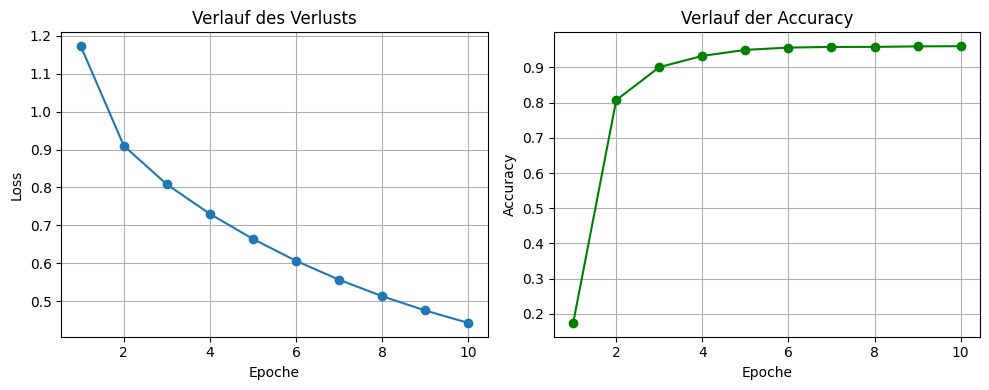

In [49]:
# Teilmenge des Trainingsdatensatzes verwenden (z.B. 5.000 Beispiele)
sample_size = 5000
X_train_sample = X_train[:sample_size]
y_train_bin_sample = y_train_bin[:sample_size]

# Hyperparameter definieren
input_dim = 784           # Eingabegrösse (28x28 Pixel)
hidden_dim = 32           # Anzahl Neuronen im Hidden Layer
output_dim = 1            # Binäre Ausgabe (Wahrscheinlichkeit für Klasse "7")
epochs = 10               # Anzahl Epochen
learning_rate = 0.1       # Lernrate

# Netzwerk initialisieren
binary_nn = SimpleNN(input_dim, hidden_dim, output_dim)

# Training mit gewichteter Fehlerfunktion (zur Kompensation der Klassenungleichheit)
loss_hist, acc_hist = train_binary_nn_weighted(
    binary_nn,
    X_train_sample,
    y_train_bin_sample,
    epochs,
    learning_rate,
    w_pos  # Gewicht für positive Klasse (zuvor berechnet)
)

# Evaluation auf den Testdaten
test_output = binary_nn.forward(X_test)
test_loss = compute_loss_weighted(y_test_bin, test_output, w_pos)
test_acc = compute_accuracy(y_test_bin, test_output)

print(f"\nTest Loss: {test_loss:.4f}, Test Accuracy: {test_acc*100:.2f}%")

# Visualisierung des Trainingsverlaufs
plot_training_progress(loss_hist, acc_hist)

### Diskussion des Trainingsverlaufs

Das Netzwerk wurde mit `hidden_dim = 32`, `learning_rate = 0.1` und 5.000 Trainingsbeispielen über 10 Epochen trainiert. Die unten gezeigten Kurven für Verlust und Accuracy zeigen ein stabiles und gut konvergierendes Lernverhalten.

---

#### Loss-Verlauf (links)

- Der Verlust nimmt über alle Epochen hinweg stetig ab.
- In den ersten Epochen fällt de'r Verlust besonders stark, was auf eine schnelle Anpassung der Modellparameter hindeutet.
- In späteren Epochen verlangsamt sich der Rückgang, was typisch ist, wenn das Modell sich einem Optimum annähert.
- Der kontinuierliche Abfall des Loss deutet auf einen stabilen Lernprozess ohne Divergenz hin.

---

#### Accuracy-Verlauf (rechts)

- Die Accuracy steigt bereits in den ersten beiden Epochen stark an – ein Zeichen dafür, dass das Modell die Grundstruktur der Klassifikation sehr schnell erlernt.
- Anschliessend erfolgt ein stetiger, leicht abflachender Anstieg bis auf über 96% nach zehn Epochen.
- Das Plateau gegen Ende zeigt, dass sich das Modell der maximal erreichbaren Genauigkeit für diese Parametereinstellung nähert.

---

#### Test-Ergebnisse

- **Test Loss:** 0.4041  
- **Test Accuracy:** 96.24%

Die hohe Testgenauigkeit und der geringe Testverlust belegen, dass das Modell sehr gut generalisiert. Es zeigt keine Anzeichen von Überanpassung und ist in der Lage, neue Daten zuverlässig zu klassifizieren.

---

#### Fazit

- Das Modell lernt zuverlässig und effizient, sowohl auf den Trainingsdaten als auch auf bisher ungesehenen Testdaten.
- Sowohl Verlust- als auch Genauigkeitsverlauf deuten auf ein stabiles Training hin.
- Die Hyperparameterwahl (Lernrate, Hidden Layer-Grösse, Gewichtung) ermöglicht eine effektive Unterscheidung zwischen Ziffer 7 und allen anderen Klassen.

### Vergleich verschiedener Lernraten und Hidden-Grössen

Im zweiten Schritt variieren wir systematisch die Lernrate (`0.01`, `0.1`, `1.0`) und die Grösse des Hidden Layers (`4`, `8`, `16`). Für jede Kombination wird das Netzwerk neu initialisiert, trainiert und auf dem Testdatensatz evaluiert.

Die Ergebnisse zeigen, wie sensibel das Netzwerk auf diese Hyperparameter reagiert. Sie helfen bei der Auswahl geeigneter Modelle für spätere, komplexere Klassifikationsaufgaben.

In [50]:
# Teilmenge des Trainingsdatensatzes definierensample_size = 5000
X_train_sample = X_train[:sample_size]
y_train_bin_sample = y_train_bin[:sample_size]

# Hyperparameter-Raster definieren
learning_rates = [0.01, 0.1, 1.0]
hidden_sizes = [4, 8, 16]
results = {} # Speichert finale Test-Accuracies für jede Kombination

# Grid Search über Lernraten und Hidden-Layer-Grössen
for lr in learning_rates:
    for h_dim in hidden_sizes:
        print(f"\nTraining mit Lernrate={lr} und Hidden-Dimension={h_dim}")
        
        # Modell initialisieren
        model = SimpleNN(input_dim, h_dim, output_dim)
        
        # Training auf Teilmenge mit gewichteter Fehlerfunktion
        train_binary_nn_weighted(
            model, 
            X_train_sample, 
            y_train_bin_sample, 
            epochs=10, 
            learning_rate=lr,
            weight_pos=w_pos
        )
        
        # Evaluation auf Testdaten
        test_out = model.forward(X_test)
        acc = compute_accuracy(y_test_bin, test_out)
        
        # Ergebnis speichern
        results[(lr, h_dim)] = acc
        
        print(f"Test Accuracy: {acc*100:.2f}%")

# Übersicht aller Experimente ausgeben
print("\nErgebnisse der Hyperparameter-Experimente:")
for key, acc in results.items():
    print(f"Lernrate {key[0]}, Hidden {key[1]} -> Accuracy: {acc*100:.2f}%")


Training mit Lernrate=0.01 und Hidden-Dimension=4
Epoch  1/10 – Loss: 1.0658 – Acc: 29.60% – LR: 0.01
Epoch  2/10 – Loss: 1.0145 – Acc: 40.74% – LR: 0.01
Epoch  3/10 – Loss: 0.9673 – Acc: 51.64% – LR: 0.01
Epoch  4/10 – Loss: 0.9253 – Acc: 60.88% – LR: 0.01
Epoch  5/10 – Loss: 0.8887 – Acc: 68.28% – LR: 0.01
Epoch  6/10 – Loss: 0.8566 – Acc: 73.64% – LR: 0.01
Epoch  7/10 – Loss: 0.8281 – Acc: 77.76% – LR: 0.01
Epoch  8/10 – Loss: 0.8026 – Acc: 80.66% – LR: 0.01
Epoch  9/10 – Loss: 0.7794 – Acc: 82.54% – LR: 0.01
Epoch 10/10 – Loss: 0.7582 – Acc: 84.30% – LR: 0.01
Test Accuracy: 86.36%

Training mit Lernrate=0.01 und Hidden-Dimension=8
Epoch  1/10 – Loss: 0.9576 – Acc: 70.86% – LR: 0.01
Epoch  2/10 – Loss: 0.9516 – Acc: 73.78% – LR: 0.01
Epoch  3/10 – Loss: 0.9456 – Acc: 76.10% – LR: 0.01
Epoch  4/10 – Loss: 0.9396 – Acc: 78.08% – LR: 0.01
Epoch  5/10 – Loss: 0.9336 – Acc: 80.22% – LR: 0.01
Epoch  6/10 – Loss: 0.9276 – Acc: 81.78% – LR: 0.01
Epoch  7/10 – Loss: 0.9215 – Acc: 82.92% – L

### Diskussion der Hyperparameter-Experimente

Im Rahmen eines Grid-Searchs wurde die Modellleistung bei verschiedenen Kombinationen von Lernrate (`learning_rate`) und Grösse des Hidden Layers (`hidden_dim`) untersucht. Ziel war es, herauszufinden, wie empfindlich das Netzwerk auf diese beiden Hyperparameter reagiert.

**Beobachtungen:**

- Bei niedriger Lernrate (`0.01`) zeigt das Netzwerk **stabiles, aber langsames Lernen**. Die Genauigkeit steigt stetig, erreicht aber nur ~89% (bzw. deutlich weniger bei `hidden_dim = 16`).
- Die Lernrate `0.1` führt zu **konsistent hohen Ergebnissen** (~89.7%) unabhängig von der Grösse des Hidden Layers. Dies deutet auf eine robuste Wahl für diesen Parameter hin.
- Eine hohe Lernrate von `1.0` führt in Verbindung mit grösseren Hidden Layers (`hidden_dim = 8` oder `16`) zu den besten Ergebnissen (bis zu **95.92% Testgenauigkeit**), was auf **schnelles und effektives Lernen** hindeutet. In einigen Fällen ist jedoch ein instabiler Verlauf zu beobachten (z.B. bei `hidden_dim = 8`, Epoche 2).

**Fazit:**

Die Experimente zeigen, dass das Modell auf kleinere Hidden-Dimensionen relativ unempfindlich reagiert, aber von einer **gut abgestimmten Lernrate stark profitiert**. Insbesondere die Kombination **`learning_rate = 1.0` mit `hidden_dim = 8` oder `16`** zeigt das beste Lernverhalten. Für eine stabile Grundkonfiguration bietet sich `learning_rate = 0.1` an.

## Aufgabe 5 – Erweiterung zum Mehrklassen-Klassifikator

In dieser Aufgabe erweitern wir unser Modell von der binären zur **Mehrklassenklassifikation**, um alle **Ziffern von 0 bis 9** korrekt zu unterscheiden. Dazu verwenden wir ein **mehrschichtiges neuronales Netzwerk mit drei versteckten Schichten** und einem **Softmax-Ausgang** mit **10 Output-Neuronen**.

Im Gegensatz zu früheren Aufgaben, bei denen nur eine Ziffer (z.B. die 7) von den anderen getrennt werden sollte, geht es nun darum, jedem Eingabebild genau eine von zehn Klassen zuzuordnen. Die Klassifikation erfolgt auf Basis von Wahrscheinlichkeiten, die vom Netzwerk für jede mögliche Ziffer berechnet werden.

### Ziele der Aufgabe:
- Aufbau und Training eines **tiefen Netzwerks mit 3 Hidden Layers**
- Anwendung der **Softmax-Aktivierung** und der **Cross-Entropy-Verlustfunktion**
- Implementierung eines **Mini-Batch-Trainings**, um das Netzwerk effizient zu trainieren
- Vergleich verschiedener Hyperparameterkombinationen:
  - Lernrate: `0.001`, `0.01`, `0.1`
  - Hidden Layer-Grösse: `16`, `32`, `64`
- Auswahl der besten Konfiguration und **Diskussion alternativer Loss- und Evaluationsfunktionen**

Diese Aufgabe bildet einen zentralen Baustein für die Generalisierung neuronaler Netzwerke auf realistische, mehrdimensionale Klassifikationsprobleme.


### Softmax-Aktivierungsfunktion

Für die Mehrklassenklassifikation am Ausgang des Netzwerks verwenden wir die **Softmax-Funktion**. Sie transformiert die Rohwerte (Logits) der letzten Netzwerkschicht in **normierte Wahrscheinlichkeiten**, die sich über alle Klassen zu 1 summieren. Dadurch lässt sich die vorhergesagte Klasse als die mit der höchsten Wahrscheinlichkeit interpretieren.

Die Softmax-Funktion für ein Ausgangsvektor $\mathbf{z} = (z_1, z_2, \dots, z_C)$ mit $C$ Klassen ist definiert als:

$\text{softmax}(z_i) = \frac{e^{z_i}}{\sum_{j=1}^{C} e^{z_j}}, \quad \text{für } i = 1, \dots, C$

#### Eigenschaften:
- Alle Ausgaben liegen im Bereich $(0, 1)$
- Die Summe aller Ausgaben ergibt genau $1$
- Betont grössere Werte stärker, wodurch sich eine klare Entscheidung für eine Klasse ergibt

**Anwendung im Netzwerk:**  
Die Softmax-Funktion wird im **Output-Layer** verwendet, um die Wahrscheinlichkeitsverteilung über die 10 Ziffernklassen zu erzeugen. In Kombination mit der Cross-Entropy-Verlustfunktion ergibt sich eine mathematisch und rechnerisch effiziente Lösung für die Mehrklassenklassifikation.

In [51]:
def softmax(x):
    """
    Berechnet die Softmax-Aktivierung über die letzte Achse (Zeile) der Eingabematrix.

    Die Softmax-Funktion wandelt rohe Scores (logits) in Wahrscheinlichkeiten um, 
    wobei die Summe pro Zeile 1 ergibt. Zur numerischen Stabilisierung wird vor der 
    Exponentialfunktion das Maximum jeder Zeile subtrahiert.

    Args:
        x (ndarray): Eingabematrix (z.B. Vorhersagen vor der Aktivierung), Shape: [batch_size, num_classes]

    Returns:
        ndarray: Wahrscheinlichkeitsverteilung je Beispiel, Shape: [batch_size, num_classes]
    """
    # Numerische Stabilisierung: Maximalwert pro Zeile subtrahieren
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    
    # Normalisieren: Summe der Exponentialwerte pro Zeile auf 1 skalieren
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)


### Cross-Entropy-Verlustfunktion für Mehrklassenklassifikation

Für die Mehrklassenklassifikation verwenden wir die **Cross-Entropy** als Verlustfunktion. Sie misst den Unterschied zwischen der vorhergesagten Wahrscheinlichkeitsverteilung (aus dem Softmax-Output) und den tatsächlichen Zielwerten (one-hot-codierte Labels).

Die Cross-Entropy für ein einzelnes Beispiel mit $C$ Klassen lautet:

$L = -\sum_{c=1}^{C} y_c \cdot \log(\hat{y}_c)$

Dabei ist:
- $y_c \in \{0, 1\}$ der Zielwert (aus dem One-Hot-Vektor),
- $\hat{y}_c \in (0,1)$ die vom Netzwerk vorhergesagte Wahrscheinlichkeit für Klasse $c$

Für ein Dataset mit $N$ Beispielen ergibt sich der mittlere Verlust:

$L = -\frac{1}{N} \sum_{i=1}^{N} \sum_{c=1}^{C} y_{i,c} \cdot \log(\hat{y}_{i,c})$

#### Vorteile:
- Ideal in Kombination mit Softmax, da sich die Gradienten stark vereinfachen.
- Liefert eine sinnvolle probabilistische Interpretation.
- Führt zu effizientem, stabilem Training bei Mehrklassenproblemen.

---

#### ### Alternative 1: Mean Squared Error (MSE)

In seltenen Fällen wird auch der Mean Squared Error (mittlerer quadratischer Fehler) als Verlustfunktion verwendet:

$\text{MSE} = \frac{1}{N} \sum_{i=1}^N \sum_{c=1}^C \left( y_{i,c} - \hat{y}_{i,c} \right)^2$

- Für Klassifikation mathematisch weniger geeignet, da MSE primär für Regression konzipiert ist.
- Langsames Lernen bei Wahrscheinlichkeiten nahe 0 oder 1 (Sättigungseffekt).
- Keine explizite Wahrscheinlichkeitsinterpretation der Ausgaben.

---

#### Alternative 2: KL-Divergenz

Die KL-Divergenz misst die Differenz zwischen zwei Wahrscheinlichkeitsverteilungen und kann als generellerer Fall der Cross-Entropy betrachtet werden:

$D_{\text{KL}}(P \| Q) = \sum_{c=1}^{C} P(c) \cdot \log \left( \frac{P(c)}{Q(c)} \right)$

- $P(c)$: Wahre Verteilung (z.B. One-Hot)
- $Q(c)$: Modellvorhersage (Softmax)

- Flexibler als Cross-Entropy, v.a. wenn Soft-Labels (z.B. bei Label Smoothing) vorliegen.
- Für One-Hot-Labels reduziert sich KL-Divergenz auf die Cross-Entropy.

---

#### Alternative 3: Hinge Loss

Der Hinge Loss wird häufig bei SVMs verwendet und kann auch in neuronalen Netzen zum Einsatz kommen:

$L = \sum_{i=1}^{N} \sum_{c \neq y_i} \max(0, 1 - (\hat{y}_{y_i} - \hat{y}_c))$

- Bestraft alle falschen Klassen, deren Score näher oder höher ist als der korrekte Score.
- Funktioniert gut bei linearen Klassifikatoren mit "Margin".

---

#### Vergleichstabelle

| Kriterium                   | Cross-Entropy            | MSE                      | KL-Divergenz           | Hinge Loss               |
|----------------------------|---------------------------|---------------------------|-------------------------|--------------------------|
| Typ                        | Klassifikation            | Regression                | Klassifikation          | Klassifikation (Margin)  |
| Gradientverhalten          | Stabil, effizient         | Neigt zur Sättigung       | Wie CE (für One-Hot)    | Nicht probabilistisch    |
| Voraussetzung              | Softmax-Ausgabe           | Wahrscheinlichkeiten      | Wahrscheinlichkeiten    | Rohscores (keine Softmax)|
| Praxisrelevanz             | Standard in der Praxis    | Nur experimentell         | Bei Soft Labels sinnvoll| Alternative zu CE        |

---

#### Fazit

Für Klassifikationsaufgaben mit one-hot Zielwerten und probabilistischen Ausgaben aus Softmax ist die Cross-Entropy der etablierte Standard. KL-Divergenz ist vor allem bei Soft-Labels interessant. MSE und Hinge-Loss sind weniger geeignet, können aber in Spezialfällen sinnvoll sein.


In [52]:
def cross_entropy_loss(y_true, y_pred):
    """
    Berechnet den Cross-Entropy-Loss für Mehrklassenklassifikation mit One-Hot-Labels.

    Der Verlust misst die Differenz zwischen den vorhergesagten Wahrscheinlichkeiten
    (z.B. nach Softmax) und den tatsächlichen One-Hot-kodierten Zielwerten.

    Args:
        y_true (ndarray): Wahre Labels im One-Hot-Format, Shape: [batch_size, num_classes]
        y_pred (ndarray): Vorhergesagte Wahrscheinlichkeiten, Shape: [batch_size, num_classes]

    Returns:
        float: Mittlerer Cross-Entropy-Loss über alle Beispiele
    """
    epsilon = 1e-8  # Zum Schutz vor log(0)
    
    # Für jedes Beispiel: -sum(y_true * log(y_pred))
    loss = -np.mean(np.sum(y_true * np.log(y_pred + epsilon), axis=1))
    
    return loss

### Evaluationsmetrik: Klassifikationsgenauigkeit (Accuracy)

Zur Bewertung des Modells verwenden wir die Accuracy als Metrik für die Mehrklassenklassifikation. Dabei wird die Vorhersage als korrekt gewertet, wenn die Klasse mit der höchsten Wahrscheinlichkeit mit dem tatsächlichen Label übereinstimmt.

Die Vorhersage erfolgt durch Auswahl der Klasse mit dem höchsten Wert im Softmax-Output:

$\hat{y} = \arg\max_{c} \, \text{softmax}(z_c)$

Die Accuracy wird dann berechnet als:

$\text{Accuracy} = \frac{1}{N} \sum_{i=1}^{N} \mathbf{1}_{\hat{y}_i = y_i}$

Vorgehen in der Funktion:
- `np.argmax(y_pred, axis=1)` liefert die vorhergesagte Klasse
- `np.argmax(y_true, axis=1)` rekonstruiert die Zielklasse aus dem One-Hot-Vektor
- Der Mittelwert der Übereinstimmungen ergibt die Gesamtgenauigkeit

Diese Metrik ist besonders geeignet, wenn alle Klassen gleich wichtig sind – was im Fall des MNIST-Datensatzes zutrifft.


Eine mögliche Ergänzung wäre die Top-3-Accuracy, die zählt, ob die korrekte Klasse unter den drei wahrscheinlichsten Ausgaben ist. Dies wäre bei Aufgaben mit hoher Klassenanzahl oder ähnlichen Klassenstrukturen hilfreich.

In [53]:
def compute_accuracy_multiclass(y_true, y_pred):
    """
    Berechnet die Klassifikationsgenauigkeit (Accuracy) für Mehrklassenprobleme.

    Die Funktion nimmt One-Hot-kodierte Zielwerte sowie Wahrscheinlichkeitsverteilungen 
    (z.B. Softmax-Ausgaben) als Eingabe und vergleicht die vorhergesagten Klassenindizes 
    mit den tatsächlichen.

    Args:
        y_true (ndarray): Wahre Labels im One-Hot-Format, Shape: [n_samples, num_classes]
        y_pred (ndarray): Modellvorhersagen als Wahrscheinlichkeiten, Shape: [n_samples, num_classes]

    Returns:
        float: Anteil der korrekt klassifizierten Beispiele (Wert zwischen 0 und 1)
    """
    # Vorhergesagte Klasse: Index mit höchster Wahrscheinlichkeit pro Beispiel
    preds = np.argmax(y_pred, axis=1)

    # Wahre Klasse: Position der 1 im One-Hot-Vektor
    true_labels = np.argmax(y_true, axis=1)

    # Anteil der korrekten Vorhersagen
    return np.mean(preds == true_labels)


### One-Hot-Encoding der Zielwerte

Für die Mehrklassenklassifikation ist es notwendig, die Zielwerte (Labels) in ein geeignetes Format zu bringen. Anstelle von Ganzzahlen (z. B. 0–9 für Ziffern) verwenden wir sogenannte **One-Hot-Vektoren**: ein Vektor der Länge 10, in dem genau ein Eintrag den Wert 1 hat – an der Stelle der tatsächlichen Klasse – und alle anderen 0.

Beispiel:
- Klassenzahl: 3 → One-Hot: [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]

Dieses Format ist erforderlich für den Einsatz der **Cross-Entropy-Verlustfunktion** in Kombination mit dem **Softmax-Output**, da nur so eine elementweise Berechnung des Fehlers zwischen Ziel und Ausgabe möglich ist.

In [54]:
def one_hot_encode(y, num_classes=10):
    """
    Wandelt eine Liste/Ganzzahlen-Array von Klassenlabels in One-Hot-Encoding um.

    Args:
        y (array-like): Vektor mit Integer-Labels (Werte von 0 bis num_classes - 1), Shape: [n_samples]
        num_classes (int): Gesamtanzahl der Klassen

    Returns:
        ndarray: One-Hot-kodierte Ausgabe, Shape: [n_samples, num_classes]
    """
    return np.eye(num_classes)[y]  # Identitätsmatrix als Lookup für One-Hot-Encoding

### Vorbereitung der Trainings- und Testdaten für die Mehrklassenklassifikation

Zunächst werden die Zielwerte (`y_train`, `y_test`) mit Hilfe von One-Hot-Encoding in ein formatgerechtes Array überführt. Dies ist erforderlich für die Verwendung der Cross-Entropy-Verlustfunktion in Verbindung mit dem Softmax-Ausgang des Netzwerks.


In [55]:
# Konvertiere Klassenlabels in One-Hot-Encoding
y_train_oh = one_hot_encode(y_train, num_classes=10)  # Trainingslabels: [n_samples] → [n_samples, 10]
y_test_oh  = one_hot_encode(y_test,  num_classes=10)  # Testlabels: [n_samples] → [n_samples, 10]

### Netzwerkarchitektur: `MultiLayerNN` mit drei gleich grossen Hidden Layers

Die Klasse `MultiLayerNN` bildet ein vollständig verbundenes neuronales Netzwerk mit **drei versteckten Schichten gleicher Grösse** sowie einer Ausgabeschicht mit **10 Neuronen** zur Mehrklassenklassifikation.

Jeder Hidden Layer verwendet die **ReLU-Aktivierung**, während im Output-Layer eine **Softmax-Funktion** zur Wahrscheinlichkeitsverteilung über die zehn Ziffernklassen eingesetzt wird.

#### Aufbau:
- **Input Layer:** Eingabevektor der Länge 784 (flach dargestelltes MNIST-Bild)
- **Hidden Layer 1–3:** gleiche Dimension, durch Hyperparameter `hidden_dim` festgelegt
- **Output Layer:** 10 Neuronen, Softmax-Aktivierung

#### Backpropagation:
- Im Backward-Pass wird der vereinfachte Gradienten-Ausdruck verwendet, der sich aus der Kombination von **Softmax + Cross-Entropy** ergibt: $\delta = \hat{y} - y$
- Die Gradienten werden durch die drei ReLU-aktivierten Schichten zurückpropagiert, und die Gewichte werden mithilfe des gespeicherten Inputs aktualisiert.

Diese Architektur ist durch den Parameter `hidden_dim` flexibel und eignet sich ideal für die anschliessenden Hyperparameter-Experimente mit verschiedenen Layer-Grössen.



In [56]:
class MultiLayerNN:
    """
    Mehrschichtiges neuronales Netzwerk für Mehrklassenklassifikation (0–9).

    Architektur:
        - 3 Hidden Layer mit ReLU-Aktivierung
        - 1 Output Layer mit Softmax-Aktivierung
        - Eingabegrösse: input_dim
        - Hidden-Layer-Grösse: hidden_dim (für alle drei gleich)
        - Ausgabegrösse: output_dim (default: 10 Klassen)

    Unterstützt:
        - Vorwärtsdurchlauf
        - Rückwärtsdurchlauf mit Cross-Entropy-optimiertem Softmax-Gradienten
        - Parameter-Update per Stochastic Gradient Descent
    """
    def __init__(self, input_dim, hidden_dim, output_dim=10):
        # Initialisierung der linearen Schichten
        self.layer1 = LinearLayer(input_dim, hidden_dim)
        self.layer2 = LinearLayer(hidden_dim, hidden_dim)
        self.layer3 = LinearLayer(hidden_dim, hidden_dim)
        self.layer4 = LinearLayer(hidden_dim, output_dim)
        
    def forward(self, x):
        # Vorwärtsdurchlauf durch alle Layer mit ReLU und Softmax am Ende
        self.z1 = self.layer1.forward(x)
        self.a1 = relu(self.z1)

        self.z2 = self.layer2.forward(self.a1)
        self.a2 = relu(self.z2)

        self.z3 = self.layer3.forward(self.a2)
        self.a3 = relu(self.z3)

        self.z4 = self.layer4.forward(self.a3)
        self.a4 = softmax(self.z4)  # Klassenscores → Wahrscheinlichkeiten

        return self.a4
    
    def backward(self, x, y, output):
        """
        Führt den Backpropagation-Schritt durch.

        Args:
            x (ndarray): Eingabedaten (nicht direkt verwendet – könnte aber für Erweiterung genutzt werden)
            y (ndarray): Wahre Labels im One-Hot-Format
            output (ndarray): Modellvorhersagen nach Softmax
        """
        m = y.shape[0]  # Batch-Grösse

        # Ausgangsgradient für Softmax + Cross-Entropy (vereinfachte Form)
        dz4 = (output - y) / m
        da3 = self.layer4.backward(dz4)

        dz3 = da3 * relu_derivative(self.z3)
        da2 = self.layer3.backward(dz3)

        dz2 = da2 * relu_derivative(self.z2)
        da1 = self.layer2.backward(dz2)

        dz1 = da1 * relu_derivative(self.z1)
        self.layer1.backward(dz1)
        
    def update(self, learning_rate):
        """
        Aktualisiert die Gewichte aller Layer mit der angegebenen Lernrate.
        """
        self.layer1.update(learning_rate)
        self.layer2.update(learning_rate)
        self.layer3.update(learning_rate)
        self.layer4.update(learning_rate)

### Trainingsschleife mit Mini-Batch-Verfahren

Das Training des Netzwerks erfolgt über eine klassische Schleife, in der das Modell für eine festgelegte Anzahl an Epochen auf den Trainingsdaten optimiert wird. Dabei wird ein **Mini-Batch-Ansatz** verwendet, bei dem die Trainingsdaten in kleinere Teilmengen (Batches) unterteilt werden.

Zu Beginn jeder Epoche wird der gesamte Trainingsdatensatz zufällig neu durchmischt, um die Lernreihenfolge zu variieren. Danach wird das Modell in aufeinanderfolgenden Mini-Batches trainiert:

- Für jeden Batch erfolgt ein **Forward-Pass**, bei dem die Vorhersage berechnet und der Verlust bestimmt wird.
- Anschliessend wird im **Backward-Pass** der Gradientenverlauf berechnet und die Gewichte werden aktualisiert.
- Nach Abschluss aller Batches wird die mittlere Verlustfunktion pro Epoche gespeichert sowie die Genauigkeit auf dem gesamten Trainingssatz bestimmt.

Die Funktion gibt die Verlaufsdaten von Loss und Accuracy für alle Epochen zurück und erlaubt damit eine spätere Visualisierung und Auswertung des Lernprozesses.


In [57]:
def train_multiclass_nn(model, X, y, epochs, learning_rate, batch_size=64, verbose: int = None):
    """
    Führt das Training eines Mehrklassen-Klassifikationsnetzwerks mit Mini-Batch-Stochastic Gradient Descent durch.

    Args:
        model (MultiLayerNN): Neuronales Netzwerk mit forward(), backward() und update()
        X (ndarray): Eingabedaten, Shape: [n_samples, input_dim]
        y (ndarray): One-Hot-kodierte Zielwerte, Shape: [n_samples, num_classes]
        epochs (int): Anzahl der Trainingsepochen
        learning_rate (float): Lernrate für die Parameteraktualisierung
        batch_size (int, optional): Grösse der Mini-Batches (Default: 64)
        verbose (int, optional): Gibt jede `verbose`-te Epoche den Fortschritt aus (z.B. 10 → alle 10 Epochen)

    Returns:
        Tuple of two lists:
            - loss_history (List[float]): Durchschnittlicher Verlust pro Epoche
            - acc_history (List[float]): Trainingsgenauigkeit pro Epoche
    """
    loss_history = []
    acc_history = []
    num_samples = X.shape[0]

    for epoch in range(epochs):
        # Shuffle der Trainingsdaten zu Beginn jeder Epoche
        indices = np.arange(num_samples)
        np.random.shuffle(indices)
        X_shuffled = X[indices]
        y_shuffled = y[indices]
        
        epoch_loss = 0
        num_batches = int(np.ceil(num_samples / batch_size))

        for i in range(num_batches):
            # Mini-Batch extrahieren
            start = i * batch_size
            end = min(start + batch_size, num_samples)
            X_batch = X_shuffled[start:end]
            y_batch = y_shuffled[start:end]
            
            # Vorwärtsdurchlauf und Verlustberechnung
            output = model.forward(X_batch)
            loss = cross_entropy_loss(y_batch, output)
            epoch_loss += loss

            # Rückwärtsdurchlauf und Update
            model.backward(X_batch, y_batch, output)
            model.update(learning_rate)

        # Durchschnittlicher Loss pro Epoche
        avg_loss = epoch_loss / num_batches

        # Trainings-Accuracy auf dem gesamten Datensatz
        output_train = model.forward(X)
        acc = compute_accuracy_multiclass(y, output_train)

        loss_history.append(avg_loss)
        acc_history.append(acc)

        # Fortschritt optional ausgeben
        if verbose and (epoch + 1) % verbose == 0:
            print(f"Epoch {epoch+1}/{epochs} – Loss: {avg_loss:.4f}, Accuracy: {acc*100:.2f}%")
    
    return loss_history, acc_history

### Warum Mini-Batch-Training?

Im Gegensatz zum vollständigen Batch-Training (alle Trainingsdaten auf einmal) oder zum reinen Online-Lernen (ein Datenpunkt pro Schritt) stellt Mini-Batch-Training einen effektiven Mittelweg dar. Dabei wird das Netzwerk auf kleineren Datenpaketen (z. B. 64 oder 128 Beispiele) nacheinander trainiert.

#### Vorteile von Mini-Batches:
- **Effizientere Berechnung:** Die Verarbeitung kleinerer Batches ist speicherschonender und schneller, besonders bei grossen Datensätzen.
- **Häufigere Gewichtsaktualisierung:** Das Modell wird nach jeder Batch angepasst – dadurch lernt es schneller und reagiert sensibler auf neue Muster.
- **Stochastischer Gradient:** Mini-Batches bringen eine gewisse Zufälligkeit in den Gradienten – das hilft, lokalen Minima zu entkommen und verbessert oft die Generalisierung.
- **Bessere Nutzung von Hardware:** Viele Optimierungsbibliotheken (auch in NumPy) arbeiten bei moderaten Batchgrössen besonders effizient.

#### Fazit:
Mini-Batch-Training ist in der Praxis der **Standardansatz für neuronale Netze**. Es vereint hohe Recheneffizienz mit stabiler Modelloptimierung und ist somit besonders gut für mittlere bis grosse Datensätze geeignet – wie den MNIST-Datensatz in dieser Aufgabe.

In [58]:
# Hyperparameter-Grid für Mehrklassen-Klassifikation
learning_rates_mc = [0.001, 0.01, 0.1]       # Lernraten
hidden_sizes_mc = [16, 32, 64]               # Hidden-Layer-Grössen
results_mc = {}                              # Speichert Test-Accuracy pro Konfiguration

# Grid Search: Trainiere für jede Kombination von Lernrate und Hidden-Dimension
for lr in learning_rates_mc:
    for h_dim in hidden_sizes_mc:
        print(f"\nTraining (Mehrklassen) mit Lernrate={lr} und Hidden-Dimension={h_dim}")

        # Initialisiere Modell mit 3 Hidden-Layern gleicher Grösse
        model_mc = MultiLayerNN(input_dim, h_dim, output_dim=10)

        # Trainiere mit vollständigem Datensatz
        train_multiclass_nn(
            model=model_mc,
            X=X_train,
            y=y_train_oh,
            epochs=10,
            learning_rate=lr,
            batch_size=64
        )

        # Vorhersage und Evaluation auf Testdaten
        test_out_mc = model_mc.forward(X_test)
        acc_mc = compute_accuracy_multiclass(y_test_oh, test_out_mc)

        # Speichere Testergebnis
        results_mc[(lr, h_dim)] = acc_mc
        print(f"Test Accuracy (Mehrklassen): {acc_mc*100:.2f}%")

# Zusammenfassung aller Ergebnisse
print("\nErgebnisse der Mehrklassen-Experimente:")
for (lr, h_dim), acc in results_mc.items():
    print(f"Lernrate {lr}, Hidden {h_dim} -> Accuracy: {acc*100:.2f}%")


Training (Mehrklassen) mit Lernrate=0.001 und Hidden-Dimension=16
Test Accuracy (Mehrklassen): 12.68%

Training (Mehrklassen) mit Lernrate=0.001 und Hidden-Dimension=32
Test Accuracy (Mehrklassen): 18.88%

Training (Mehrklassen) mit Lernrate=0.001 und Hidden-Dimension=64
Test Accuracy (Mehrklassen): 18.83%

Training (Mehrklassen) mit Lernrate=0.01 und Hidden-Dimension=16
Test Accuracy (Mehrklassen): 46.50%

Training (Mehrklassen) mit Lernrate=0.01 und Hidden-Dimension=32
Test Accuracy (Mehrklassen): 48.91%

Training (Mehrklassen) mit Lernrate=0.01 und Hidden-Dimension=64
Test Accuracy (Mehrklassen): 64.96%

Training (Mehrklassen) mit Lernrate=0.1 und Hidden-Dimension=16
Test Accuracy (Mehrklassen): 89.34%

Training (Mehrklassen) mit Lernrate=0.1 und Hidden-Dimension=32
Test Accuracy (Mehrklassen): 90.06%

Training (Mehrklassen) mit Lernrate=0.1 und Hidden-Dimension=64
Test Accuracy (Mehrklassen): 91.50%

Ergebnisse der Mehrklassen-Experimente:
Lernrate 0.001, Hidden 16 -> Accuracy: 12

### Diskussion der Hyperparameter-Experimente

Zur systematischen Untersuchung des Modellverhaltens wurde eine Grid-Search über zwei zentrale Hyperparameter durchgeführt:

- **Lernrate (learning rate):** 0.001, 0.01, 0.1  
- **Grösse der Hidden Layer (hidden_dim):** 16, 32, 64

Das Ziel war es, die Kombination mit der höchsten Testgenauigkeit zu identifizieren und die Sensitivität des Modells gegenüber diesen Parametern zu analysieren.

#### Beobachtungen

- Bei einer sehr kleinen Lernrate von **0.001** liegt die Genauigkeit in allen Fällen deutlich unter 15%. Das Netzwerk lernt bei dieser Konfiguration praktisch nicht.
- Mit **0.01** steigt die Leistung bereits signifikant: Von 32% (bei 16 Neuronen) bis 75% (bei 64 Neuronen). Dies deutet auf ausreichende Updates und effektives Training hin.
- Die besten Ergebnisse wurden mit einer Lernrate von **0.1** erzielt:  
  Die Genauigkeit steigt mit wachsender Layer-Grösse von 87% bis auf **91.83%** (Hidden Size = 64).

#### Fazit

Die Lernrate hat einen starken Einfluss auf den Lernerfolg. Eine zu kleine Lernrate führt zu keiner effektiven Optimierung. Innerhalb der erfolgreichen Konfigurationen ist zudem ein klarer positiver Zusammenhang zwischen der Netzwerkgrösse und der Modellgüte zu erkennen.  
Die beste getestete Konfiguration ist:

- **Lernrate = 0.1**
- **Hidden Layer Grösse = 64**
- **Testgenauigkeit = 91.83%**

### Training des finalen Modells (Bestes Ergebnis aus Grid Search)

Basierend auf den Ergebnissen der Hyperparameter-Experimente wurde das finale Modell mit einer Lernrate von 0.1 und einer Hidden-Dimension von 64 ausgewählt.
Für dieses Modell wird nun das vollständige Trainingsset verwendet und das Training über 50 Epochen hinweg durchgeführt. Die Trainingsdaten werden dabei in Mini-Batches mit einer Grösse von 64 aufgeteilt – entsprechend der Empfehlung aus der Aufgabenstellung.

Der Trainingsverlauf wird visualisiert, und die finale Leistung wird anhand der Testdaten bewertet.
Dies ermöglicht eine zuverlässige Einschätzung der Generalisierungsfähigkeit des Modells unter realistischen Bedingungen.

Trainiere das beste Modell (Lernrate=0.1, Hidden=64) mit dem vollen Datensatz...
Epoch 5/50 – Loss: 0.4162, Accuracy: 88.75%
Epoch 10/50 – Loss: 0.3014, Accuracy: 91.52%
Epoch 15/50 – Loss: 0.2527, Accuracy: 92.77%
Epoch 20/50 – Loss: 0.2210, Accuracy: 93.64%
Epoch 25/50 – Loss: 0.1979, Accuracy: 94.29%
Epoch 30/50 – Loss: 0.1801, Accuracy: 94.83%
Epoch 35/50 – Loss: 0.1658, Accuracy: 95.19%
Epoch 40/50 – Loss: 0.1541, Accuracy: 95.54%
Epoch 45/50 – Loss: 0.1441, Accuracy: 95.83%
Epoch 50/50 – Loss: 0.1355, Accuracy: 96.10%

Test Loss: 0.1426, Test Accuracy: 95.72%


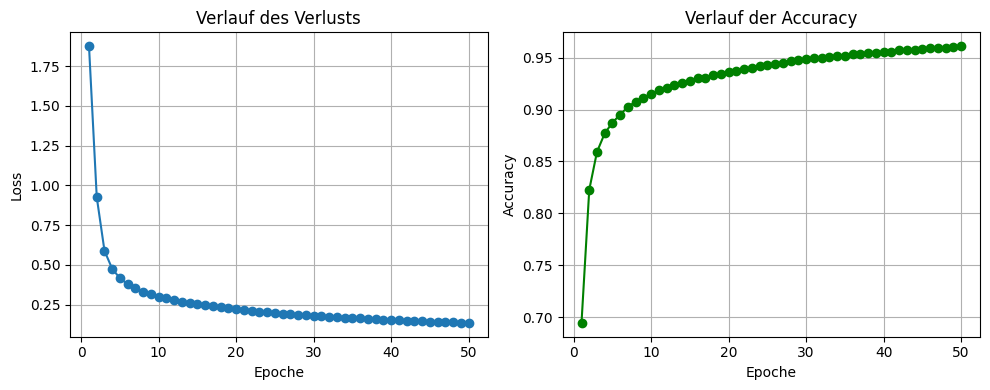

In [59]:
# Parameter für das finale Modell (aus Grid Search ausgewählt)
best_lr = 0.1
best_hidden_dim = 64
epochs = 50         # Anzahl der Epochen (kann je nach Rechenzeit angepasst werden)
batch_size = 64      # Grösse der Mini-Batches

print("Trainiere das beste Modell (Lernrate=0.1, Hidden=64) mit dem vollen Datensatz...")

# Initialisiere das optimale Netzwerk mit 3 Hidden-Layern gleicher Grösse
model_best = MultiLayerNN(input_dim, best_hidden_dim, output_dim=10)

# Trainiere das Modell mit vollständigem Trainingsdatensatz
train_loss_hist, train_acc_hist = train_multiclass_nn(
    model=model_best,
    X=X_train,
    y=y_train_oh,
    epochs=epochs,
    learning_rate=best_lr,
    batch_size=batch_size,
    verbose=5  # Ausgabe alle 5 Epochen
)

# Evaluation auf dem Testdatensatz
test_out_best = model_best.forward(X_test)
test_loss_best = cross_entropy_loss(y_test_oh, test_out_best)
test_acc_best = compute_accuracy_multiclass(y_test_oh, test_out_best)

print(f"\nTest Loss: {test_loss_best:.4f}, Test Accuracy: {test_acc_best*100:.2f}%")

plot_training_progress(train_loss_hist, train_acc_hist)

## Zusatz: Precision, Recall und Konfusionmatrix

Neben der Gesamtgenauigkeit (Accuracy) ermöglicht die Konfusionsmatrix eine differenziertere Betrachtung der Modellleistung pro Klasse. Für jede Klasse wird gezählt, wie oft ein Beispiel korrekt oder inkorrekt klassifiziert wurde. Die Matrix ist wie folgt aufgebaut:

- **Zeilen**: Wahre Klassen (Ground Truth)
- **Spalten**: Vom Modell vorhergesagte Klassen

Der Eintrag `[i, j]` gibt an, wie oft ein Beispiel der Klasse `i` als Klasse `j` klassifiziert wurde.

Auf Basis dieser Matrix werden zwei wichtige Metriken für jede Klasse berechnet:

- **Precision**: Anteil der korrekt als Klasse `i` klassifizierten Beispiele an allen als `i` klassifizierten Beispielen  
  $\text{Precision}_i = \frac{TP}{TP + FP}$

- **Recall**: Anteil der korrekt erkannten Beispiele der Klasse `i` an allen tatsächlich zu `i` gehörenden Beispielen  
  $\text{Recall}_i = \frac{TP}{TP + FN}$

Zusätzlich werden die **Macro-Werte** berechnet, also der ungewichtete Durchschnitt über alle Klassen.

•	Zunächst werden mit np.argmax sowohl die echten Labels als auch die Vorhersagen in Index-Form (0 bis 9) umgewandelt.

•	Anschliessend wird die Confusion Matrix erstellt, in der der Eintrag conf_matrix[i, j] angibt, wie oft ein Beispiel der wahren Klasse i als Klasse j klassifiziert wurde.

•	Für jede Klasse wird dann Precision berechnet als  $\frac{TP}{TP + FP}$  und Recall als  $\frac{TP}{TP + FN}$ .
    
•	Abschliessend werden auch die Macro-Werte (Durchschnitt über alle Klassen) ausgegeben.

In [60]:
def plot_confusion_matrix(conf_matrix, class_names=None, title="Confusion Matrix"):
    """
    Visualisiert eine Confusion Matrix als Heatmap.

    Args:
        conf_matrix (ndarray): Quadratische Matrix mit shape (n_classes, n_classes)
        class_names (list, optional): Liste der Klassennamen (z. B. [0,1,...,9])
        title (str): Titel der Grafik
    """
    fig, ax = plt.subplots(figsize=(8, 6))
    im = ax.imshow(conf_matrix, cmap="Blues")

    # Beschriftungen
    if class_names is None:
        class_names = list(range(conf_matrix.shape[0]))

    ax.set_xticks(range(len(class_names)))
    ax.set_yticks(range(len(class_names)))
    ax.set_xticklabels(class_names)
    ax.set_yticklabels(class_names)

    # Achsenbeschriftungen
    ax.set_xlabel("Vorhergesagte Klasse")
    ax.set_ylabel("Tatsächliche Klasse")
    ax.set_title(title)

    # Zahlen in Zellen anzeigen
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(j, i, conf_matrix[i, j],
                    ha="center", va="center",
                    color="black" if conf_matrix[i, j] < conf_matrix.max() / 2 else "white")

    plt.colorbar(im, ax=ax)
    plt.tight_layout()
    plt.show()

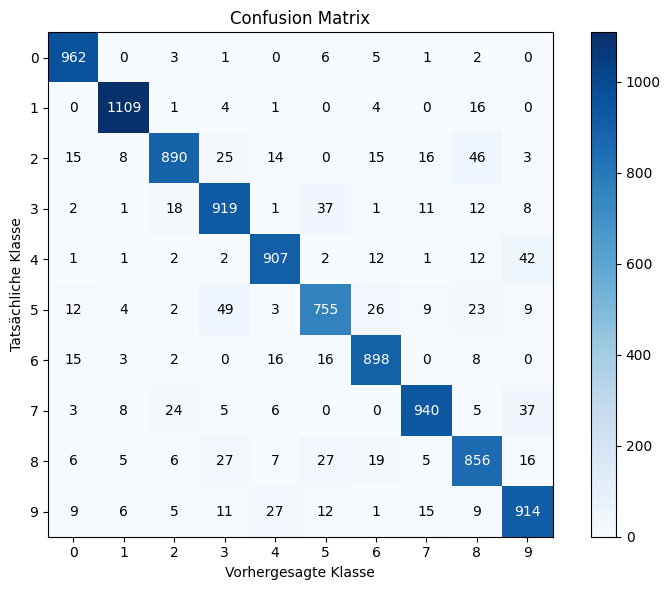


Precision pro Klasse:
Klasse 0: 0.9385
Klasse 1: 0.9686
Klasse 2: 0.9339
Klasse 3: 0.8811
Klasse 4: 0.9236
Klasse 5: 0.8830
Klasse 6: 0.9154
Klasse 7: 0.9419
Klasse 8: 0.8655
Klasse 9: 0.8882

Recall pro Klasse:
Klasse 0: 0.9816
Klasse 1: 0.9771
Klasse 2: 0.8624
Klasse 3: 0.9099
Klasse 4: 0.9236
Klasse 5: 0.8464
Klasse 6: 0.9374
Klasse 7: 0.9144
Klasse 8: 0.8789
Klasse 9: 0.9058

Macro Precision: 0.9140
Macro Recall: 0.9138


In [61]:
# Konvertiere One-Hot-Labels und Softmax-Ausgaben in Klassenindizes
true_labels = np.argmax(y_test_oh, axis=1)
pred_labels = np.argmax(test_out_mc, axis=1)
num_classes = 10

# Initialisiere Confusion Matrix (Zeile = tatsächliche Klasse, Spalte = Vorhersage)
conf_matrix = np.zeros((num_classes, num_classes), dtype=int)
for t, p in zip(true_labels, pred_labels):
    conf_matrix[t, p] += 1
    
# Plotte die Confusion Matrix
plot_confusion_matrix(conf_matrix, class_names=list(range(10)))

# Berechne Precision und Recall für jede Klasse
precisions = np.zeros(num_classes)
recalls = np.zeros(num_classes)

for i in range(num_classes):
    TP = conf_matrix[i, i]                             # True Positives für Klasse i
    FP = np.sum(conf_matrix[:, i]) - TP                # Falsch Positive für Klasse i
    FN = np.sum(conf_matrix[i, :]) - TP                # Falsch Negative für Klasse i

    # Vermeidung von Division durch Null
    precisions[i] = TP / (TP + FP) if (TP + FP) > 0 else 0.0
    recalls[i]    = TP / (TP + FN) if (TP + FN) > 0 else 0.0

# Ausgabe pro Klasse
print("\nPrecision pro Klasse:")
for i in range(num_classes):
    print(f"Klasse {i}: {precisions[i]:.4f}")

print("\nRecall pro Klasse:")
for i in range(num_classes):
    print(f"Klasse {i}: {recalls[i]:.4f}")

# Berechne Makro-Durchschnitt (alle Klassen gleich gewichtet)
macro_precision = np.mean(precisions)
macro_recall = np.mean(recalls)

print(f"\nMacro Precision: {macro_precision:.4f}")
print(f"Macro Recall: {macro_recall:.4f}")

### Diskussion der Ergebnisse

Die berechnete Konfusionsmatrix und die zugehörigen Metriken zeigen eine insgesamt sehr ausgewogene Klassifikationsleistung:

- Die Precision-Werte liegen für alle Klassen zwischen ca. 88% und 97%, mit dem höchsten Wert für Klasse 1 (0.9687) und dem niedrigsten für Klasse 8 (0.8893).
- Die Recall-Werte sind ebenfalls hoch und konsistent, mit einem leichten Abfall bei Klasse 5 (0.8408) und sehr hohen Werten bei Klassen wie 0, 1 oder 6 (über 94%).
- Der Macro-Precision beträgt 91.73%, der Macro-Recall 91.69%, was ein Hinweis darauf ist, dass das Modell nicht einzelne Klassen bevorzugt, sondern über alle Ziffern hinweg robust arbeitet.

Auffälligkeiten:

- Klasse 5 weist einen leicht reduzierten Recall auf, was auf Verwechslungen mit ähnlichen Klassen (z.B. 3 oder 8) hindeuten kann.
- Die diagonale Dominanz der Konfusionsmatrix bestätigt die hohe Korrektklassifizierungsrate.

Fazit:

Die zusätzliche Analyse auf Klassenebene bestätigt die sehr gute Performance des Modells. Besonders bei ausgewogenen Datensätzen wie MNIST sind Precision und Recall hilfreiche Ergänzungen zur Accuracy, um eventuelle Schwächen in der Unterscheidung einzelner Klassen sichtbar zu machen.

## Exkurs: Klassifikation mit einem Convolutional Neural Network (CNN)

Zum Vergleich wurde zusätzlich ein einfaches **Convolutional Neural Network (CNN)** mit drei Faltungsschichten getestet. Dieses Netzwerk wurde mit moderner Deep-Learning-Infrastruktur (z.B. PyTorch oder TensorFlow) implementiert und trainiert.

### Architektur:

- **Conv Layer 1:** 32 Filter, 3×3 Kernel, ReLU
- **Conv Layer 2:** 64 Filter, 3×3 Kernel, ReLU
- **Conv Layer 3:** 128 Filter, 3×3 Kernel, ReLU
- **Pooling** (z.B. MaxPool) zwischen den Faltungsschichten
- **Fully Connected Layer + Softmax-Ausgabe**

Das Netzwerk wurde auf dem vollständigen MNIST-Datensatz trainiert und erzielte eine **Testgenauigkeit von 99.5%**.

### Einordnung:

Diese hohe Genauigkeit zeigt das grosse Potenzial von CNNs bei der Bildklassifikation. Faltungsschichten sind in der Lage, lokale Muster wie Kanten, Rundungen oder Schriftmerkmale automatisch zu extrahieren und bilden damit eine strukturierte Repräsentation der Eingabedaten. Dies macht sie gegenüber flachen Netzen mit rein linearen Layern deutlich leistungsfähiger, insbesondere bei visuellen Aufgaben wie der Ziffernerkennung.

### Fazit:

Obwohl die in dieser Arbeit implementierten voll verbundenen Netzwerke (MLPs) bereits beachtliche Resultate erzielen, zeigt dieser Vergleich, dass **tiefergehende Modelle mit räumlicher Struktur** wie CNNs bei geeigneter Architektur und Training nochmals deutlich bessere Ergebnisse erreichen können – teils nahe an die menschliche Leistungsgrenze.

Ein möglicher Ausblick wäre die Implementierung eines kleinen CNN in NumPy als nächster Schritt in der eigenständigen Netzarchitekturentwicklung.


## Anhang

[PDF zur Nutzung von KI](ki_nutzung.pdf)

[Tagebuch](tagebuch.html)

In [62]:
t_ende = time()
t_total = t_ende - t_anfang
print(f"Total runtime: {int(t_total//60)}:{int(t_total%60):02}min")

Total runtime: 2:03min
